In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet121,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [7]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet121(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 48s 15ms/step - loss: 0.3855 - acc: 0.8798 - val_loss: 1.4129 - val_acc: 0.6569
Epoch 2/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.2251 - acc: 0.9288 - val_loss: 0.2756 - val_acc: 0.9047
Epoch 3/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.2143 - acc: 0.9262 - val_loss: 0.4010 - val_acc: 0.9060
Epoch 4/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.1637 - acc: 0.9427 - val_loss: 0.2904 - val_acc: 0.8920
Epoch 5/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.1269 - acc: 0.9587 - val_loss: 0.4216 - val_acc: 0.8640
Epoch 6/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.1330 - acc: 0.9590 - val_loss: 0.4791 - val_acc: 0.8196
Epoch 7/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.1221 - acc: 0.9574 - val_loss: 0.3433 - val_acc: 0

3144/3144 [==============================] - 39s 12ms/step - loss: 0.0043 - acc: 0.9984 - val_loss: 0.1565 - val_acc: 0.9784
Epoch 61/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.1413 - val_acc: 0.9682
Epoch 62/100
3144/3144 [==============================] - 39s 12ms/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.1585 - val_acc: 0.9720
Epoch 63/100
3144/3144 [==============================] - 39s 12ms/step - loss: 0.0139 - acc: 0.9946 - val_loss: 0.1627 - val_acc: 0.9606
Epoch 64/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.0126 - acc: 0.9952 - val_loss: 0.2205 - val_acc: 0.9657
Epoch 65/100
3144/3144 [==============================] - 39s 12ms/step - loss: 0.0299 - acc: 0.9876 - val_loss: 0.1438 - val_acc: 0.9809
Epoch 66/100
3144/3144 [==============================] - 38s 12ms/step - loss: 0.0104 - acc: 0.9971 - val_loss: 0.1908 - val_acc: 0.9606
Epoch 67/100
3144/3144 [=======================

3145/3145 [==============================] - 38s 12ms/step - loss: 0.0689 - acc: 0.9749 - val_loss: 0.1728 - val_acc: 0.9504
Epoch 19/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0618 - acc: 0.9797 - val_loss: 0.1168 - val_acc: 0.9695
Epoch 20/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0586 - acc: 0.9806 - val_loss: 0.2044 - val_acc: 0.9606
Epoch 21/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0509 - acc: 0.9828 - val_loss: 0.3645 - val_acc: 0.9529
Epoch 22/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0382 - acc: 0.9889 - val_loss: 0.1605 - val_acc: 0.9720
Epoch 23/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0710 - acc: 0.9777 - val_loss: 0.2390 - val_acc: 0.9631
Epoch 24/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0383 - acc: 0.9892 - val_loss: 0.2332 - val_acc: 0.9453
Epoch 25/100
3145/3145 [=======================

3145/3145 [==============================] - 39s 12ms/step - loss: 0.0076 - acc: 0.9968 - val_loss: 0.1494 - val_acc: 0.9784
Epoch 78/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0120 - acc: 0.9965 - val_loss: 0.2039 - val_acc: 0.9682
Epoch 79/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0144 - acc: 0.9946 - val_loss: 0.1475 - val_acc: 0.9758
Epoch 80/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.2399 - val_acc: 0.9580
Epoch 81/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0047 - acc: 0.9981 - val_loss: 0.3164 - val_acc: 0.9567
Epoch 82/100
3145/3145 [==============================] - 39s 12ms/step - loss: 0.0035 - acc: 0.9987 - val_loss: 0.2237 - val_acc: 0.9720
Epoch 83/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0095 - acc: 0.9971 - val_loss: 0.1665 - val_acc: 0.9733
Epoch 84/100
3145/3145 [=======================

3145/3145 [==============================] - 38s 12ms/step - loss: 0.0421 - acc: 0.9847 - val_loss: 0.2417 - val_acc: 0.9186
Epoch 36/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0272 - acc: 0.9908 - val_loss: 0.1295 - val_acc: 0.9656
Epoch 37/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0192 - acc: 0.9921 - val_loss: 0.1197 - val_acc: 0.9733
Epoch 38/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0469 - acc: 0.9854 - val_loss: 0.2352 - val_acc: 0.9351
Epoch 39/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0279 - acc: 0.9905 - val_loss: 0.3451 - val_acc: 0.9084
Epoch 40/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0717 - acc: 0.9774 - val_loss: 1.0120 - val_acc: 0.7316
Epoch 41/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0297 - acc: 0.9911 - val_loss: 0.1125 - val_acc: 0.9733
Epoch 42/100
3145/3145 [=======================

3145/3145 [==============================] - 38s 12ms/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.1340 - val_acc: 0.9809
Epoch 95/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0100 - acc: 0.9978 - val_loss: 0.1749 - val_acc: 0.9529
Epoch 96/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0356 - acc: 0.9895 - val_loss: 0.1978 - val_acc: 0.9618
Epoch 97/100
3145/3145 [==============================] - 37s 12ms/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.1475 - val_acc: 0.9733
Epoch 98/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0478 - acc: 0.9854 - val_loss: 0.1268 - val_acc: 0.9669
Epoch 99/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0257 - acc: 0.9886 - val_loss: 0.1092 - val_acc: 0.9758
Epoch 100/100
786/786 [==============================] - 4s 5ms/step
[2] Test acurracy: 0.9796 (3785.9819 s)
Train on 3145 samples, validate on 786 samples
Epoch 1/100
3145/3145 [======

3145/3145 [==============================] - 38s 12ms/step - loss: 0.0490 - acc: 0.9838 - val_loss: 0.2691 - val_acc: 0.9504
Epoch 53/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0222 - acc: 0.9921 - val_loss: 0.2772 - val_acc: 0.9542
Epoch 54/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0216 - acc: 0.9949 - val_loss: 0.2862 - val_acc: 0.9580
Epoch 55/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0234 - acc: 0.9930 - val_loss: 0.2015 - val_acc: 0.9593
Epoch 56/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0165 - acc: 0.9933 - val_loss: 0.2431 - val_acc: 0.9555
Epoch 57/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0354 - acc: 0.9889 - val_loss: 0.2464 - val_acc: 0.9529
Epoch 58/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0332 - acc: 0.9886 - val_loss: 0.3696 - val_acc: 0.9389
Epoch 59/100
3145/3145 [=======================

3145/3145 [==============================] - 38s 12ms/step - loss: 0.1419 - acc: 0.9568 - val_loss: 0.3612 - val_acc: 0.9186
Epoch 11/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.1592 - acc: 0.9501 - val_loss: 0.2935 - val_acc: 0.9237
Epoch 12/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.1235 - acc: 0.9606 - val_loss: 0.1889 - val_acc: 0.9466
Epoch 13/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.1107 - acc: 0.9650 - val_loss: 0.4157 - val_acc: 0.8575
Epoch 14/100
3145/3145 [==============================] - 37s 12ms/step - loss: 0.1104 - acc: 0.9612 - val_loss: 0.2909 - val_acc: 0.9288
Epoch 15/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0890 - acc: 0.9707 - val_loss: 0.2138 - val_acc: 0.9300
Epoch 16/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0825 - acc: 0.9727 - val_loss: 0.2530 - val_acc: 0.9478
Epoch 17/100
3145/3145 [=======================

3145/3145 [==============================] - 38s 12ms/step - loss: 0.0084 - acc: 0.9971 - val_loss: 0.2387 - val_acc: 0.9606
Epoch 70/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0487 - acc: 0.9847 - val_loss: 0.2520 - val_acc: 0.9529
Epoch 71/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0035 - acc: 0.9990 - val_loss: 0.2016 - val_acc: 0.9644
Epoch 72/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0169 - acc: 0.9940 - val_loss: 0.2233 - val_acc: 0.9440
Epoch 73/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0100 - acc: 0.9971 - val_loss: 0.2040 - val_acc: 0.9631
Epoch 74/100
3145/3145 [==============================] - 37s 12ms/step - loss: 0.0039 - acc: 0.9987 - val_loss: 0.2090 - val_acc: 0.9580
Epoch 75/100
3145/3145 [==============================] - 38s 12ms/step - loss: 0.0069 - acc: 0.9984 - val_loss: 0.2401 - val_acc: 0.9593
Epoch 76/100
3145/3145 [=======================

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9387


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

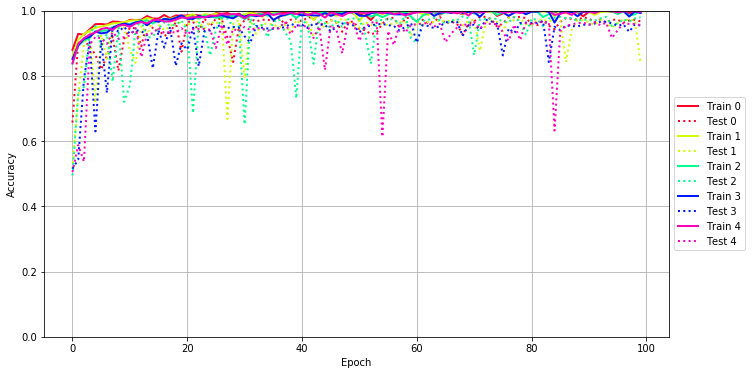

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

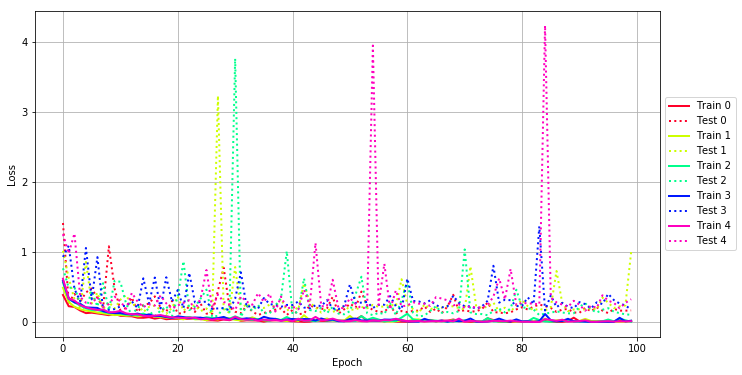

In [12]:
plot_loss(history)

Plotting the confusion matrix


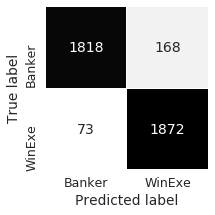

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


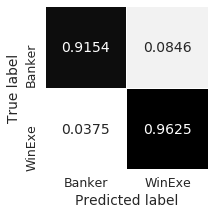

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'acc': [0.8797709923664122, 0.9287531806615776, 0.926208651399491, 0.9427480916030534, 0.9586513994910941, 0.958969465648855, 0.9573791348600509, 0.9666030534351145, 0.9656488549618321, 0.9621501272264631, 0.9720101781170484, 0.9710559796437659, 0.9720101781170484, 0.9834605597964376, 0.9758269720101781, 0.9758269720101781, 0.9866412213740458, 0.9767811704834606, 0.9850508905852418, 0.9847328244274809, 0.9853689567430025, 0.9866412213740458, 0.9853689567430025, 0.9837786259541985, 0.9821882951653944, 0.9923664122137404, 0.9904580152671756, 0.9926844783715013, 0.9856870229007634, 0.9907760814249363, 0.9809160305343512, 0.9949109414758269, 0.9907760814249363, 0.9917302798982188, 0.9942748091603053, 0.9990458015267175, 0.9926844783715013, 0.9933206106870229, 0.9917302798982188, 0.9961832061068703, 0.9958651399491094, 0.9974554707379135, 1.0, 0.9984096692111959, 0.9917302798982188, 0.9952290076335878, 0.9952290076335878, 0.9920483460559797, 0.9939567430025446, 0.9917302798982188, 0.989821

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

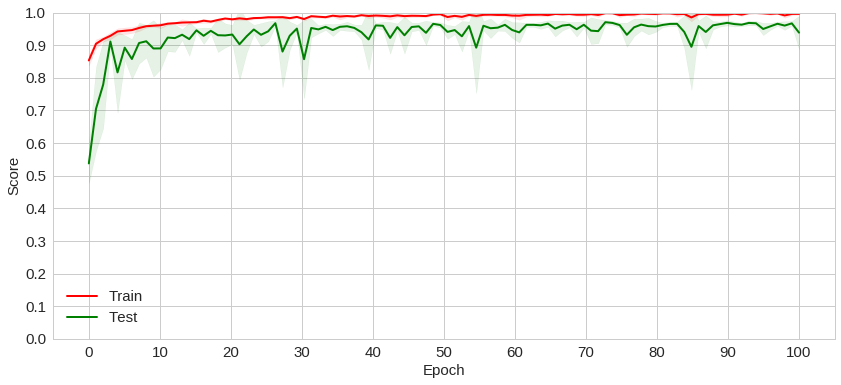

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

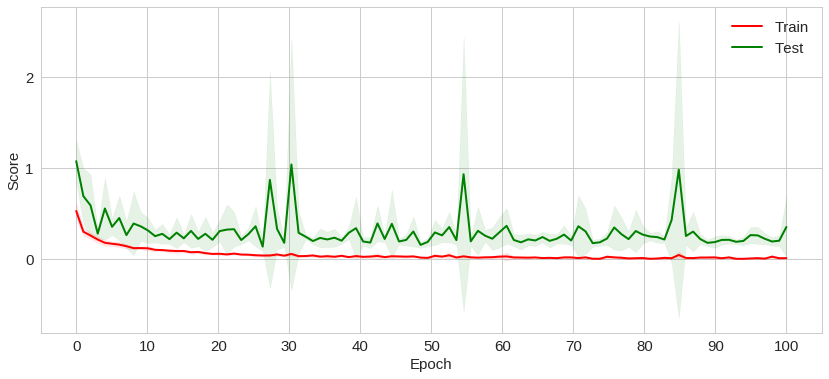

In [19]:
plot_mean_loss(history)

In [21]:
hist = [{'acc': [0.8797709923664122, 0.9287531806615776, 0.926208651399491, 0.9427480916030534, 0.9586513994910941, 0.958969465648855, 0.9573791348600509, 0.9666030534351145, 0.9656488549618321, 0.9621501272264631, 0.9720101781170484, 0.9710559796437659, 0.9720101781170484, 0.9834605597964376, 0.9758269720101781, 0.9758269720101781, 0.9866412213740458, 0.9767811704834606, 0.9850508905852418, 0.9847328244274809, 0.9853689567430025, 0.9866412213740458, 0.9853689567430025, 0.9837786259541985, 0.9821882951653944, 0.9923664122137404, 0.9904580152671756, 0.9926844783715013, 0.9856870229007634, 0.9907760814249363, 0.9809160305343512, 0.9949109414758269, 0.9907760814249363, 0.9917302798982188, 0.9942748091603053, 0.9990458015267175, 0.9926844783715013, 0.9933206106870229, 0.9917302798982188, 0.9961832061068703, 0.9958651399491094, 0.9974554707379135, 1.0, 0.9984096692111959, 0.9917302798982188, 0.9952290076335878, 0.9952290076335878, 0.9920483460559797, 0.9939567430025446, 0.9917302798982188, 0.989821882951654, 0.9866412213740458, 0.9713740458015268, 0.9923664122137404, 0.9952290076335878, 0.9949109414758269, 0.996501272264631, 0.9910941475826972, 0.9987277353689568, 0.9984096692111959, 0.9990458015267175, 0.9974554707379135, 0.9945928753180662, 0.9952290076335878, 0.9875954198473282, 0.9971374045801527, 0.9936386768447837, 0.9945928753180662, 0.9891857506361323, 0.996501272264631, 0.9974554707379135, 0.9990458015267175, 1.0, 0.9993638676844784, 0.9837786259541985, 0.9917302798982188, 0.9987277353689568, 1.0, 0.9996819338422391, 0.9987277353689568, 0.9996819338422391, 0.9974554707379135, 0.9987277353689568, 0.9971374045801527, 0.9949109414758269, 0.9984096692111959, 0.9993638676844784, 0.9990458015267175, 0.9949109414758269, 0.982824427480916, 0.9968193384223919, 0.9949109414758269, 0.9987277353689568, 0.9984096692111959, 0.996501272264631, 0.9990458015267175, 0.9961832061068703, 0.9923664122137404, 0.9968193384223919, 0.9968193384223919], 'val_loss': [1.4128684258370114, 0.2755510708769213, 0.4009506855789558, 0.2904497006342402, 0.4215636771394761, 0.4791292769330278, 0.3432977425249286, 0.20848008462025522, 1.0806525933179696, 0.474059446652395, 0.17001858586977972, 0.20058598484384815, 0.3503702143171691, 0.1424327991793957, 0.24290045783316583, 0.26198441772857795, 0.3658344303586892, 0.2066368486452966, 0.14727195268591542, 0.3002372567732422, 0.12217173233789214, 0.12457687307247985, 0.22731881340068624, 0.1441195820129253, 0.25752683290460276, 0.11995315782990888, 0.11693150915513233, 0.4462219287154257, 0.7748799144807429, 0.21666217080389624, 0.14674020822933878, 0.12384754852903593, 0.23449886376225687, 0.14953081194043863, 0.10052585747836126, 0.1287813514992926, 0.15072922488835308, 0.17608742537083438, 0.1937758776689424, 0.10042828314829963, 0.1715375975755108, 0.11204887567227573, 0.12102505935942369, 0.23696548446707144, 0.2085134521230811, 0.18496177917350945, 0.19720357645022255, 0.359798983454212, 0.1188915221581503, 0.18158440683936414, 0.2617643587360025, 0.2063050030146665, 0.43455861089182546, 0.22529266596200204, 0.1726620012260867, 0.1455779934939964, 0.144723428645215, 0.2296878113590215, 0.122852954266355, 0.1565318163208135, 0.14128800927338295, 0.15852211321614976, 0.1626722872437107, 0.2205363141805918, 0.14376800781968443, 0.19080181635594945, 0.12605825172834279, 0.22182984579301698, 0.38835083121886327, 0.1508773175919348, 0.16816008152438564, 0.14884251731457046, 0.15291947482634158, 0.1843135880335444, 0.27819580395794824, 0.14132705493445544, 0.13529228679454156, 0.12404076942191501, 0.1387300416214154, 0.17969960546317887, 0.21108538413176542, 0.17794917161532572, 0.21891949414575523, 0.24910412487361505, 0.22798626721520662, 0.2012906971258417, 0.1432730807314577, 0.17864023170963428, 0.18567763929570635, 0.13608257636177, 0.13183424627092052, 0.20217380154016398, 0.15324336749630516, 0.21008119098699005, 0.1632145669291981, 0.12675651175314187, 0.1880640916318042, 0.16209014598753543, 0.16179053045333994, 0.16559177079560783], 'val_acc': [0.6569250322963565, 0.9047013982429892, 0.9059720468036404, 0.8919949175593511, 0.8640406612671315, 0.8195679798211045, 0.8614993653576135, 0.9212198226394314, 0.8157560355781448, 0.9123252858958069, 0.947903431279838, 0.9453621352188469, 0.8907242699075382, 0.9644218556762802, 0.9466327832493424, 0.9402795430968647, 0.9224904701397713, 0.9313850068833959, 0.9644218551461246, 0.874205845662569, 0.9656925037067757, 0.9669631512071156, 0.9351969515050381, 0.9758576879507401, 0.9517153753713247, 0.9758576879507401, 0.974587039390089, 0.9174078780177891, 0.8424396452788628, 0.9491740793103336, 0.970775095828758, 0.974587039390089, 0.9669631512071156, 0.9720457433290979, 0.9720457433290979, 0.9682337997677668, 0.97712833545108, 0.959339263554298, 0.9720457438592535, 0.9758576874205845, 0.9669631512071156, 0.9796696320422268, 0.9783989840117313, 0.955527319992967, 0.963151207115629, 0.9707750952986023, 0.9631512076457847, 0.9351969509748825, 0.9669631512071156, 0.9656925042369314, 0.9428208391578558, 0.9402795436270204, 0.9275730622617535, 0.9326556549138914, 0.9606099110546379, 0.9758576879507401, 0.9783989834815756, 0.9479034307496823, 0.97712833545108, 0.9783989840117313, 0.9682337992376112, 0.9720457443894092, 0.9606099110546379, 0.96569250317662, 0.9809402795425667, 0.9606099110546379, 0.9656925037067757, 0.9606099115847936, 0.9250317672610737, 0.9606099121149492, 0.9669631512071156, 0.9809402795425667, 0.9809402800727224, 0.9733163913595934, 0.9504447268106735, 0.9606099110546379, 0.9796696315120712, 0.9796696315120712, 0.9809402795425667, 0.97712833545108, 0.959339263554298, 0.955527319992967, 0.9695044472681067, 0.9542566719624714, 0.9428208386277002, 0.96569250317662, 0.97712833545108, 0.9745870399202446, 0.9720457433290979, 0.9796696315120712, 0.9758576874205845, 0.9644218551461246, 0.9733163913595934, 0.963151207115629, 0.9720457433290979, 0.9720457433290979, 0.963151207115629, 0.9695044472681067, 0.9720457433290979, 0.9669631512071156], 'loss': [0.38545664834005533, 0.225126045862682, 0.214305142334096, 0.16372249787317888, 0.12686421195135164, 0.13295487635804495, 0.12211880358481074, 0.11056072809010668, 0.09730197839514748, 0.11555022171890462, 0.08882032537183537, 0.08433173275813366, 0.08152351266308747, 0.06136764004665401, 0.06043562611669264, 0.06925710963035528, 0.048134258938787394, 0.06122542532639573, 0.039560659817874946, 0.04622198049359393, 0.042723437217858075, 0.04338221982389252, 0.0477735690494677, 0.04975417241544176, 0.05993857056094433, 0.024252449650478576, 0.024373577588946385, 0.01974072810585324, 0.036435944470606565, 0.02575263287375904, 0.05179321347574677, 0.016368208935605148, 0.023971245479864796, 0.02231670561087799, 0.021880485620124516, 0.005110465453742939, 0.022372062733145397, 0.023271518282419155, 0.02631817660011581, 0.015652137099456873, 0.011244489849314305, 0.007682771718394783, 0.0021678322501630987, 0.005597258519587011, 0.02272550481197625, 0.01589966857075364, 0.014177240391580258, 0.02510856877883266, 0.01909472023209266, 0.020779891049713915, 0.02601705710059448, 0.03600542696523741, 0.08440810981435871, 0.01750269868741708, 0.020078274010755855, 0.021742371525899827, 0.008944101086425928, 0.022877313848014662, 0.005119268208876627, 0.004287377074452121, 0.00324421522115396, 0.00763730129562088, 0.013902556106782838, 0.01257299885437255, 0.029884746586751377, 0.010376352010466309, 0.021360888043195247, 0.01811358062579307, 0.036064359659886545, 0.014379536305989954, 0.007810219148784591, 0.0026879522397891447, 0.000550966972084072, 0.0021621397426513393, 0.053429071569303405, 0.02696080360439862, 0.00485189950782936, 0.0005855620705147172, 0.0007030121380599949, 0.005086252206429883, 0.0011942792909646735, 0.014239520323560444, 0.0032086636549425313, 0.008277539588946085, 0.020873154204899814, 0.00453370614700182, 0.0017783982010220777, 0.001684158140370081, 0.012124541788274766, 0.0617158423270023, 0.009523551700834918, 0.019282033898845523, 0.0037992686799001784, 0.005985961083446566, 0.011852303358110005, 0.003862047442309849, 0.00907144049793511, 0.022818106715056425, 0.01244233338509281, 0.012880602291388595]},
{'acc': [0.8597774246728288, 0.9103338632750397, 0.9284578696532925, 0.938950715459208, 0.9475357710651828, 0.9513513515408732, 0.9551669316375199, 0.9605723370618775, 0.9621621621621622, 0.9647058823529412, 0.9691573926868045, 0.9707472178818501, 0.9691573926868045, 0.9774244833257885, 0.9736089030396199, 0.9669316375198728, 0.975516693353274, 0.9748807631160572, 0.9796502384737679, 0.9806041335453101, 0.9828298887122416, 0.9888712241653418, 0.9777424483306836, 0.9891891891891892, 0.9869634340222575, 0.9907790143084261, 0.983147853736089, 0.9872813990840094, 0.9799682035165674, 0.9841017488076311, 0.9885532591414944, 0.993322734499205, 0.989825119236884, 0.9809220985691574, 0.989825119236884, 0.9926868044515104, 0.990779014497948, 0.985691573926868, 0.9917329093799682, 0.9949125598079639, 0.9879173290937997, 0.9961844197517359, 0.9710651828298887, 0.9904610492845787, 0.9885532591414944, 0.990779014497948, 0.9841017488076311, 0.9904610492845787, 0.9930047694753578, 0.9949125596942507, 0.9672496025437202, 0.9930047694753578, 0.9952305246422893, 0.9926868044704625, 0.989825119236884, 0.9949125596184419, 0.9961844197138314, 0.9980922098569157, 0.9955484896661367, 0.9926868044515104, 0.997456279809221, 0.9898251192747883, 0.9872813990461049, 0.9971383147853736, 0.9945945945945946, 0.9958664546899841, 0.9945945945945946, 0.9968203499510482, 0.9904610492845787, 0.9952305246422893, 0.9949125596184419, 0.9955484896661367, 0.9968203497615262, 0.9949125596184419, 0.9961844197327837, 0.992368839427663, 0.9968203497615262, 0.9965023847376788, 0.9945945945945946, 0.9993640699523052, 0.9980922098569157, 0.9987281399046105, 0.9971383147853736, 0.9968203497804784, 0.9834658187599364, 0.9977742450225903, 0.9920508744227677, 0.9904610492845787, 0.9968203497615262, 0.9968203497615262, 0.995866454879506, 0.9869634340222575, 0.9955484896661367, 0.997456279809221, 0.9977742448330683, 0.9987281399046105, 0.9971383147853736, 0.9996820349761526, 0.9993640699523052, 0.9955484896850889], 'val_loss': [1.0159165167626534, 0.6283814138128557, 0.3206156167668544, 0.19265882030091516, 0.8571902751248999, 0.2655278830611296, 0.41848880562009455, 0.1790596243283183, 0.2823973444453974, 0.19452840832604745, 0.31883360823952894, 0.38386557984898106, 0.23481317989727538, 0.2606656169542526, 0.14322528715628144, 0.21603775929669083, 0.23425373691904333, 0.1727555575413255, 0.11677564253068455, 0.20442460501523874, 0.36452514968715305, 0.1604866852827427, 0.2390292871097084, 0.23319767756771495, 0.15659129570344044, 0.19325616515452473, 0.11372336966717858, 3.2291558066175994, 0.1838017971546368, 0.13131777661006527, 0.7844653907354983, 0.1799164663955247, 0.25939745701489253, 0.20970182850217547, 0.21994960949662598, 0.19964370949539822, 0.24837753017914052, 0.2167983881503571, 0.330156645911693, 0.1598546902729677, 0.22712252517364478, 0.17735676249813848, 0.5529294212588106, 0.2753375956901816, 0.21112491102810976, 0.13466973608014893, 0.19503360514235196, 0.14647397177152302, 0.16571693882700436, 0.22710144600868962, 0.17490758441190732, 0.17946844012891214, 0.2149813057476792, 0.19560833160390184, 0.24492435211033747, 0.21518887962989566, 0.22236404503854443, 0.2491523359778012, 0.22693943379046372, 0.6110114528132252, 0.25250642454441524, 0.18393498106087078, 0.13123790906865443, 0.2516362097326272, 0.18513062905814054, 0.20573988998114456, 0.20599211122809244, 0.22883935294236393, 0.22320230721113812, 0.1992178796144776, 0.17925480583033337, 0.7938836413569949, 0.22369036641630696, 0.20098541549089396, 0.21800207666924057, 0.2768510811020645, 0.1493894023141002, 0.2038535133737931, 0.14754603593632443, 0.2399045163748517, 0.31635864145587117, 0.22374180548497932, 0.1665209717746426, 0.19060589705549857, 0.16324648130554753, 0.2114025333374706, 0.728152205688342, 0.26752873473460176, 0.15584569193354145, 0.17902290927256284, 0.18120387521022624, 0.1781542812084984, 0.1965264717712951, 0.17748845576216246, 0.34901072754986784, 0.27585939759931444, 0.1995622486440581, 0.22434863942680866, 0.23648729656330178, 0.9969599035769897], 'val_acc': [0.5165394402035624, 0.7379134872184152, 0.896946565037162, 0.9351145038167938, 0.7175572519083969, 0.926208651399491, 0.8524173027989822, 0.9465648854961832, 0.9465648854961832, 0.9491094147582697, 0.8804071246819338, 0.8396946566402154, 0.9541984732824428, 0.926208650792828, 0.9732824427480916, 0.9567430025445293, 0.9402035623409669, 0.950381679389313, 0.9694656488549618, 0.960559796437659, 0.9529262086513995, 0.9720101781170484, 0.9631043256997456, 0.94529262086514, 0.9656488549618321, 0.9592875318066157, 0.9745547073791349, 0.6679389312977099, 0.9592875318066157, 0.9707379134860051, 0.7926208651399491, 0.9707379134860051, 0.9287531806615776, 0.960559796437659, 0.9592875318066157, 0.9580152665689095, 0.9491094147582697, 0.9567430025445293, 0.9325699745547074, 0.9720101781170484, 0.9541984732824428, 0.9669211195928753, 0.9211195928753181, 0.9402035623409669, 0.9541984732824428, 0.9707379134860051, 0.9631043256997456, 0.9758269720101781, 0.9694656488549618, 0.9541984732824428, 0.9478371501272265, 0.9656488549618321, 0.955470737913486, 0.9656488549618321, 0.9592875318066157, 0.955470737913486, 0.9618320610687023, 0.9643765903307888, 0.9681933842239185, 0.9223918575063613, 0.9669211189862122, 0.9567430025445293, 0.965648854355169, 0.9643765897241258, 0.9694656488549618, 0.9669211195928753, 0.9694656488549618, 0.9694656488549618, 0.955470737913486, 0.9681933842239185, 0.9720101781170484, 0.8765903307888041, 0.9631043256997456, 0.9681933842239185, 0.9656488549618321, 0.9363867678411741, 0.9783715012722646, 0.9681933842239185, 0.9758269720101781, 0.9580152671755725, 0.9567430025445293, 0.9720101781170484, 0.9732824427480916, 0.9669211195928753, 0.9720101781170484, 0.9694656488549618, 0.8422391857506362, 0.9427480916030534, 0.9707379134860051, 0.9707379134860051, 0.9643765903307888, 0.9567430025445293, 0.9720101781170484, 0.9643765897241258, 0.9478371501272265, 0.9618320610687023, 0.9732824427480916, 0.9707379134860051, 0.9707379128793421, 0.8371501272264631], 'loss': [0.48924251046203465, 0.2848423943136758, 0.21709758050396258, 0.18317234099195567, 0.16233048548000983, 0.15170505816777294, 0.13510536198490944, 0.12395000686137589, 0.11092270902033735, 0.099148364946104, 0.10123233732268427, 0.08933836368574437, 0.09525778216142533, 0.07996016075103196, 0.0859996090099713, 0.10681020469835623, 0.07508666087030796, 0.06891478903603478, 0.061751699252187355, 0.05858264767044018, 0.05089514903984786, 0.038244688380598454, 0.07098744171530909, 0.038323612551144526, 0.040597809932900915, 0.026556256455065763, 0.04662875643855817, 0.03539155933573629, 0.061957469826567156, 0.0520793866534941, 0.031038488906294414, 0.022451599786466724, 0.03292014419657529, 0.06772679384406922, 0.031803922059935395, 0.025216599528060334, 0.02148610720949896, 0.044034884577329805, 0.025139243901841277, 0.013602064501940953, 0.03336163195635081, 0.014703849955263514, 0.09688417139464607, 0.025792592680244596, 0.03230012605212546, 0.02979284549348163, 0.04994601871172745, 0.022296718156642324, 0.018712234882703006, 0.018458893227676708, 0.08722432284824704, 0.019751229583743268, 0.011929123043948829, 0.01709377985623101, 0.03052414428407181, 0.01398922340691405, 0.009342819226155019, 0.005973031754776301, 0.00927001577421663, 0.02599015277387487, 0.009827095616885738, 0.03567416460023984, 0.0372666405845546, 0.008626051663031686, 0.016927484152742346, 0.010318612711450799, 0.015295643519405839, 0.008077944476315532, 0.02867173208324468, 0.012022826193239328, 0.012654391676511405, 0.014406206045615886, 0.010290159693958821, 0.0119627614554427, 0.011659658798542236, 0.028987589131264143, 0.007569359171757473, 0.01200728353825679, 0.014437709514755547, 0.0019584044822692887, 0.004654796618813747, 0.0034914024627514823, 0.00946815671513673, 0.008812090117368748, 0.04870762110144397, 0.006714271459647415, 0.02436475785545759, 0.029954856301218104, 0.012773373999478886, 0.010453723809381633, 0.015171713533456657, 0.044200970591504914, 0.014970088550607734, 0.009616444780789641, 0.01105109776069484, 0.006225592263950929, 0.007058028455557885, 0.001401771452625421, 0.0016408760785085346, 0.016333234543260144]},
{'acc': [0.8375198728234665, 0.8918918920814138, 0.9087440381558028, 0.9170111287947869, 0.9364069952305246, 0.9376788553259141, 0.9399046106823677, 0.9497615262321145, 0.9548489666515769, 0.9558028616852147, 0.9586645469377454, 0.9647058823718934, 0.9643879173290938, 0.9707472179955633, 0.9602543720380301, 0.9723370429252782, 0.9726550079491256, 0.9717011128965357, 0.9726550079680778, 0.9802861685404148, 0.9771065184725108, 0.9818759937165082, 0.9748807631160572, 0.9847376788553259, 0.9834658187599364, 0.9783783785679003, 0.9796502384737679, 0.983147853925611, 0.9837837837837838, 0.9847376790448479, 0.9742448330683625, 0.9828298887122416, 0.9875993640889045, 0.9895071542130366, 0.9847376788553259, 0.9907790143084261, 0.9920508744227677, 0.9853736089030206, 0.9904610492845787, 0.9774244833068363, 0.9910969793512256, 0.9837837837837838, 0.993322734499205, 0.993322734499205, 0.9949125596184419, 0.9882352941365993, 0.9920508744038156, 0.992368839427663, 0.9930047694753578, 0.9952305246422893, 0.9952305246422893, 0.995866454879506, 0.9812400635930048, 0.987917329131704, 0.9802861685309388, 0.9879173290937997, 0.9977742448330683, 0.9939586645468999, 0.9961844197517359, 0.9815580286737087, 0.9656597774244833, 0.9847376788553259, 0.9930047694753578, 0.9952305248318113, 0.9904610494741006, 0.9939586645468999, 0.9971383147853736, 0.9965023847376788, 0.9984101748807631, 0.9955484896661367, 0.9910969793322735, 0.9949125596184419, 0.9990461049284579, 0.9980922098758679, 0.9866454689984102, 0.9965023847376788, 0.9968203497615262, 0.9996820349761526, 0.9965023847376788, 0.9945945945945946, 0.9961844197138314, 0.9961844197706881, 0.9802861685404148, 0.9895071542130366, 0.997456279809221, 0.9984101748807631, 0.9968203497615262, 0.9965023847376788, 0.9949125596184419, 0.9961844197138314, 0.9977742448330683, 0.9965023847376788, 0.9993640699523052, 0.9990461049284579, 0.9977742448330683, 0.9895071542130366, 0.997138314823278, 0.9853736089030206, 0.9885532591414944, 1.0], 'val_loss': [0.7667986808235712, 0.48769888801277445, 0.4954458182397993, 0.26361987609463644, 0.17288877338208922, 0.4453652545936529, 0.21956944689699673, 0.5540734007291059, 0.1636762101151068, 0.5893942910950375, 0.5741543671538053, 0.26010901152639726, 0.0959087461446419, 0.20987436316585117, 0.2340914594535609, 0.15298625760244883, 0.08375341976511722, 0.1625643909088888, 0.22550973431672308, 0.08202829071659472, 0.36506747969594466, 0.8681879097159771, 0.17009270074007127, 0.21859678662303272, 0.33716131172334873, 0.46237021210098656, 0.0737859566421094, 0.0885605798766453, 0.2176273125022014, 0.13759610783213955, 3.760167049253583, 0.07297395549847273, 0.2310739252357411, 0.16134425719048232, 0.24171534533264072, 0.12946284232994673, 0.1196661330783223, 0.23516150984165926, 0.34506847540929864, 1.0120186020146804, 0.11247795980373923, 0.14985445885902446, 0.6224068348881322, 0.17092867673819934, 0.1559189619311622, 0.20348280070497093, 0.12619063048851223, 0.2172127471445543, 0.11964640563661634, 0.10994294736391133, 0.1545978611934527, 0.39596719501282945, 0.6465387172080487, 0.12451150505057046, 0.09736390823721128, 0.1319013800341387, 0.11257070726501749, 0.26731423634159923, 0.09913709168730893, 0.3125216617763194, 0.5812083561960993, 0.13241032629314414, 0.0789399732599798, 0.09177955815748669, 0.15929460139253768, 0.22598078643024277, 0.132156227581421, 0.14287482554631536, 0.12472784063462342, 0.15579394402510774, 1.0358463029635467, 0.13715630064239087, 0.113803494678884, 0.11327468918733602, 0.09655942249588156, 0.1581863213998155, 0.19121708014307687, 0.1367789315648481, 0.1924488887302814, 0.4607852326610262, 0.21071963506928398, 0.19737583558275493, 0.17895816850826193, 0.09830172841200775, 0.12045393771824899, 0.13285126857750656, 0.1523655012119831, 0.13596725225449052, 0.12343170554722238, 0.12464186937967227, 0.21652067111237486, 0.2682724852134756, 0.1823640045147904, 0.13400103329110374, 0.17489561231145706, 0.1978294245010418, 0.1474523707011563, 0.12677354199850918, 0.1091963229072932, 0.10363655474281723], 'val_acc': [0.494910941475827, 0.7519083969465649, 0.7659033078880407, 0.9312977099236641, 0.9529262086513995, 0.8931297709923665, 0.9287531806615776, 0.7824427480916031, 0.950381679389313, 0.7201017811704835, 0.7709923670188767, 0.9465648854961832, 0.9707379134860051, 0.916030534351145, 0.9211195930269839, 0.9440203562340967, 0.9643765903307888, 0.9541984732824428, 0.9567430025445293, 0.9694656488549618, 0.9389312977099237, 0.6857506361323156, 0.9656488549618321, 0.9389312977099237, 0.8625954198473282, 0.9414758269720102, 0.9758269720101781, 0.9758269720101781, 0.9491094147582697, 0.9516539440203562, 0.6513994910941476, 0.9770992366412213, 0.9478371501272265, 0.9567430025445293, 0.9185750637648973, 0.9656488549618321, 0.9732824427480916, 0.9351145038167938, 0.9083969459582224, 0.7315521628498728, 0.9732824427480916, 0.9541984726757797, 0.8371501281364577, 0.9745547073791349, 0.960559796437659, 0.9465648854961832, 0.9732824427480916, 0.950381679389313, 0.9732824427480916, 0.9758269720101781, 0.9732824427480916, 0.9274809169405289, 0.8371501272264631, 0.9720101781170484, 0.9707379134860051, 0.9745547073791349, 0.9732824427480916, 0.9592875318066157, 0.9847328244274809, 0.9147582706300964, 0.9020356234096693, 0.9681933842239185, 0.9720101781170484, 0.9770992366412213, 0.9707379134860051, 0.9592875318066157, 0.9707379134860051, 0.9707379134860051, 0.9821882951653944, 0.9770992366412213, 0.8638676852367003, 0.9732824427480916, 0.9745547073791349, 0.9758269720101781, 0.9745547073791349, 0.9669211195928753, 0.9643765903307888, 0.9809160305343512, 0.9643765910891177, 0.926208651399491, 0.9758269727685069, 0.9720101781170484, 0.9529262086513995, 0.9758269720101781, 0.9783715012722646, 0.9809160305343512, 0.9770992366412213, 0.9770992366412213, 0.9681933842239185, 0.9732824427480916, 0.9707379134860051, 0.9694656488549618, 0.9758269720101781, 0.9809160305343512, 0.9529262086513995, 0.9618320610687023, 0.9732824427480916, 0.9669211195928753, 0.9758269720101781, 0.9796437659033079], 'loss': [0.5634905292802092, 0.3257429028542887, 0.2823541107115192, 0.23321127637581152, 0.19550856806764258, 0.1726027964506245, 0.17091591623515506, 0.14803747848647578, 0.12586699874867316, 0.13021573624403374, 0.12210364740679487, 0.10474906672733955, 0.10928713813933451, 0.09457857455756213, 0.12086092391908643, 0.08510489759638029, 0.08721864881595102, 0.0857528120563595, 0.08451599250347701, 0.06250184773688096, 0.06367091995520319, 0.05691152287022298, 0.07245821639161042, 0.04657784049859676, 0.049670562683789735, 0.06790676728151561, 0.05640964029454559, 0.05036073916714597, 0.0524745108242408, 0.047485519057237476, 0.08056280923287705, 0.05066839695977719, 0.03456750856875331, 0.030899658695355447, 0.04207035228935779, 0.027154288769200657, 0.019163137070711742, 0.046876225676772514, 0.027918936689465716, 0.07172102944211758, 0.029670671210735324, 0.04538269589058403, 0.019892170919558486, 0.021134280554484946, 0.013668879584167952, 0.03332510775899802, 0.020995782321977498, 0.02524709442731464, 0.020862625706045017, 0.01299482811935345, 0.01556573697674534, 0.01428326726677333, 0.0844957429889015, 0.031404756112038995, 0.060568528556648425, 0.035795587588762175, 0.00866584532604729, 0.019197751920661386, 0.012498153320814236, 0.06394430480435467, 0.11849946490576305, 0.037298510531600215, 0.022185350544395337, 0.013286127732394468, 0.0237867965589504, 0.019934989386778592, 0.009998645875950911, 0.009154172637888537, 0.006588100960835576, 0.014725195422612386, 0.023807634420941668, 0.01712327065057203, 0.0032378593659033407, 0.0051393991143558184, 0.05601380796983116, 0.009689387425318337, 0.008099137421810091, 0.003018128324977397, 0.013999467568555846, 0.012613862156799502, 0.009203345441301643, 0.009552712955325915, 0.05875073314995308, 0.028184144519008875, 0.008526380800987061, 0.00476878806983827, 0.00970048771351513, 0.013922571136049085, 0.017459164477989526, 0.010004717388939162, 0.007480717108517896, 0.008278475320461994, 0.002289475292004486, 0.004232491779132846, 0.009985829859748562, 0.035622242646848504, 0.009700756327623712, 0.04777685940541054, 0.025744578423495264, 0.002293011444299304]},
{'acc': [0.8521462639678263, 0.8937996820539283, 0.9138314785373609, 0.9192368839427663, 0.9357710652207343, 0.9303656598342811, 0.9329093801577254, 0.9468998410364403, 0.9554848966613673, 0.9602543720190779, 0.9564387917518615, 0.963751987470921, 0.9675675675865197, 0.9554848966613673, 0.9704292528011461, 0.9656597774244833, 0.9748807631160572, 0.9723370429252782, 0.978060413354531, 0.9853736089409251, 0.9748807631160572, 0.9745627980922098, 0.9834658187599364, 0.9796502384737679, 0.9815580286168522, 0.9837837837837838, 0.9860095389507154, 0.9802861685214627, 0.9764705882542463, 0.9879173291127519, 0.9812400635930048, 0.9872813990461049, 0.9828298887122416, 0.9850556438791733, 0.9910969795217953, 0.9713831478726883, 0.9818759936406996, 0.9869634340222575, 0.9930047694753578, 0.9904610494741006, 0.9853736089219729, 0.987917329131704, 0.9853736089030206, 0.9850556438791733, 0.9926868046410322, 0.9837837837837838, 0.9907790143084261, 0.9895071542130366, 0.9977742448330683, 0.9977742448330683, 0.9844197138693829, 0.9837837837837838, 0.9920508744227677, 0.9949125596184419, 0.9930047694753578, 0.993322734688727, 0.988871224184294, 0.9885532593310163, 0.9891891891891892, 0.9907790143084261, 0.9965023847376788, 0.9971383147853736, 0.9980922098758679, 0.9837837837837838, 0.9926868044515104, 0.9958664546899841, 0.9930047694753578, 0.9990461049284579, 0.9926868044515104, 0.9961844197138314, 0.994594594632499, 0.9812400635930048, 0.9987281399046105, 0.9993640699523052, 0.9971383147853736, 0.9939586645468999, 0.9841017488076311, 0.9939586645468999, 0.9980922098758679, 0.9888712241653418, 0.9968203497615262, 0.9968203497615262, 0.9996820349761526, 0.9965023847945355, 0.9634340224470735, 0.9926868044515104, 0.9977742448330683, 0.9952305246517654, 0.9828298887122416, 0.9965023847376788, 0.9961844197138314, 0.9987281399046105, 0.9996820349761526, 0.9996820349761526, 0.9990461049284579, 0.9990461049284579, 0.9993640699902097, 0.9818759936406996, 0.9974562798281732, 0.9926868044515104], 'val_loss': [0.9287957893376435, 1.089006374355491, 0.4705911381857389, 0.2969158167450786, 1.0567299620492465, 0.32359857305543116, 0.9261581921243789, 0.16839344818476806, 0.17449125643753216, 0.18403373051994024, 0.2231180283783653, 0.23267631433695632, 0.2945565508427359, 0.19966212241097564, 0.6237252836160684, 0.2632648399616319, 0.6350502050256608, 0.19436912413013496, 0.63874855368314, 0.2896297478304261, 0.45593733405907644, 0.19784426435107796, 0.7015545306769946, 0.27987775655401725, 0.28437300583225633, 0.29043577092939055, 0.1873820244071593, 0.1940483625684379, 0.1981168664688524, 0.1675907748042779, 0.33375846893756483, 0.7089934497745757, 0.21611603230010462, 0.23084791074566183, 0.19268133929212586, 0.3414425482314658, 0.257547048597689, 0.24048588167089238, 0.21774675994969278, 0.24360206961375838, 0.24251261590618603, 0.29244690759074293, 0.2067998731295571, 0.19348301365023654, 0.23891337880386043, 0.2271104924778902, 0.31247136300014916, 0.1939325364870576, 0.18245732564237396, 0.2321773810885638, 0.5372214882424855, 0.26909268850285284, 0.27724604956041377, 0.28624850765591053, 0.20146911786798075, 0.24311888575880924, 0.2464461335177716, 0.369647229301021, 0.22563565169098496, 0.17876549949514048, 0.6204855801504656, 0.30048074414384845, 0.2940167748025214, 0.26419745042503034, 0.31034687443286224, 0.23960152186356182, 0.20954184919244992, 0.22211262721179703, 0.3752426607475045, 0.2692196669377524, 0.22452293384734912, 0.22463089541197961, 0.18815694910144723, 0.22185550887450461, 0.30396656380633724, 0.8027862711321637, 0.27642763204844173, 0.3175692460843322, 0.3110593071517845, 0.22631073583233818, 0.23065588970457704, 0.3513607458707215, 0.25396738185752205, 1.3650074298884611, 0.16439837899826865, 0.38029060779681273, 0.21073633124317226, 0.27338369441685667, 0.2184822132694535, 0.19703596896247857, 0.28384861157372526, 0.2555006268752962, 0.19309039762049307, 0.28063545288917524, 0.25610712768910476, 0.40260834462224615, 0.31273648872888943, 0.26371204489770966, 0.23656314193050712, 0.1783436692909885], 'val_acc': [0.5152671755819982, 0.5432569975692201, 0.7913486002055743, 0.9033078881923783, 0.6297709924043287, 0.9096692105892658, 0.7480916024467721, 0.9503816795409787, 0.9351145053334515, 0.9503816809059706, 0.9287531800549146, 0.9402035617343039, 0.9363867678411741, 0.9262086529161487, 0.8231552162849872, 0.9402035617343039, 0.8867684479888159, 0.9503816787826499, 0.8307888034645837, 0.8994910953609088, 0.8804071240752708, 0.9478371502788923, 0.8295165401985324, 0.9376590324722174, 0.9389312971032606, 0.9516539434136931, 0.9554707388234805, 0.9465648870128408, 0.9503816796926445, 0.947837151037221, 0.9211195933303153, 0.9020356228030062, 0.9529262095613941, 0.947837151643884, 0.9452926217751345, 0.9440203556274337, 0.9465648848895202, 0.9491094150616013, 0.9592875327166104, 0.9541984734341085, 0.9567430040611868, 0.9465648848895202, 0.9605597979543167, 0.9567430019378662, 0.9567430040611868, 0.9363867685995029, 0.9503816787826499, 0.9605597965893248, 0.9580152680855671, 0.9541984741924373, 0.9338422385790875, 0.9503816787826499, 0.9541984726757797, 0.9580152665689095, 0.9592875311999527, 0.9554707394301436, 0.9529262080447365, 0.9389312971032606, 0.9503816802993076, 0.9618320625853599, 0.9020356228030062, 0.9554707394301436, 0.9529262095613941, 0.9465648864061778, 0.9516539455370139, 0.9643765918474464, 0.9656488551134979, 0.9656488564784896, 0.9223918578096928, 0.9554707394301436, 0.956743002696195, 0.9414758278820048, 0.972010179633706, 0.9669211205028699, 0.9592875311999527, 0.8625954192406652, 0.9452926205618084, 0.9312977100753299, 0.9618320604620393, 0.9631043272164032, 0.9618320625853599, 0.9618320625853599, 0.9681933857405762, 0.8422391851439731, 0.9503816802993076, 0.9402035617343039, 0.9541984747991004, 0.9529262101680571, 0.9516539449303508, 0.9567430040611868, 0.9567430040611868, 0.9605597979543167, 0.9656488564784896, 0.9656488564784896, 0.9605597979543167, 0.9541984726757797, 0.9580152680855671, 0.9351145047267885, 0.9580152680855671, 0.9541984741924373], 'loss': [0.5893798508970082, 0.33859484299946285, 0.27999904190792757, 0.2582449020187123, 0.20836873649603233, 0.20486239578651888, 0.20142960250140754, 0.15433348590931567, 0.13700029400498598, 0.1262223989156405, 0.1275102501880194, 0.11536951053692161, 0.10679520327828837, 0.1203025392027178, 0.09289965385568161, 0.10853309950218291, 0.08218288664337373, 0.08444180097105204, 0.0709002333990815, 0.05823207298598722, 0.08029186370133294, 0.07034968756293265, 0.05547368311617873, 0.06416723787879337, 0.061209350386678886, 0.05154707389876294, 0.04359476748748056, 0.05598377794358992, 0.07255814511844198, 0.04010845007217935, 0.0511873617803823, 0.04032962355867845, 0.05300329603900354, 0.045197759393383476, 0.02888968166856714, 0.07447571928934187, 0.051457374604842336, 0.043773419247860226, 0.02140843683975158, 0.036971705908248935, 0.044146424512392195, 0.03315537026498484, 0.04310187766748956, 0.040536660202060766, 0.021460841961252385, 0.05052557186192473, 0.026158114633151288, 0.035497727936995474, 0.011600335257791208, 0.010799530999568796, 0.04512455206340703, 0.048989219579102385, 0.022175850447960232, 0.021649527846611977, 0.023408360390915865, 0.01652575740161306, 0.03542308671391067, 0.03320712349910603, 0.03819031727884116, 0.024062622238442136, 0.009098141367801883, 0.007228539667023102, 0.005502505371857798, 0.04564096449203611, 0.017520418362129354, 0.011186036852699045, 0.020435111887348794, 0.004616983025723443, 0.021782263254729026, 0.010528178610729738, 0.017454532026265124, 0.04974381683574951, 0.0049249763177256056, 0.002778118188467598, 0.0071829691365200565, 0.020028429542699074, 0.04854622591710361, 0.018662954001007852, 0.007243520581125155, 0.03785861255911983, 0.008171718206588685, 0.009951528531378165, 0.0023591938730446248, 0.011290738064099276, 0.11424015440514669, 0.025233004443548823, 0.010596023385845338, 0.01535074992360035, 0.045972061154709476, 0.010140755102753718, 0.010030167099141734, 0.005350446611734244, 0.0021080959629330752, 0.0013595815673558237, 0.00261050833505347, 0.0026797733755626646, 0.001908419373925403, 0.06025757654444189, 0.0077063489096040804, 0.018767366648706443]},
{'acc': [0.8381558030512072, 0.8979332273828964, 0.9154213036565978, 0.9265500795102082, 0.9332273449920508, 0.9437201907790143, 0.9472178060413354, 0.9411764707777572, 0.953577106518283, 0.9567567567946611, 0.9500794912938663, 0.9605723370429253, 0.9650238473767886, 0.96120826709062, 0.9707472178249935, 0.9726550081386475, 0.9666136724960255, 0.9669316375198728, 0.9723370429252782, 0.9790143084260732, 0.9774244834963581, 0.9799682034976153, 0.9796502384737679, 0.9793322736394424, 0.9853736089030206, 0.9837837837837838, 0.9895071542130366, 0.9872813990461049, 0.9895071542130366, 0.9869634340222575, 0.9767885532591415, 0.9869634340222575, 0.9863275039745628, 0.983147853736089, 0.993322734499205, 0.9866454689984102, 0.9907790143084261, 0.989825119236884, 0.9942766295707473, 0.9891891891891892, 0.9955484898556587, 0.985691573926868, 0.9936406995230525, 0.9907790143084261, 0.9786963434022258, 0.9942766295707473, 0.9888712242032462, 0.983147853736089, 0.9926868044515104, 0.9961844197138314, 0.9961844197138314, 0.9914149443561209, 0.9952305246422893, 0.997456279809221, 0.9914149443561209, 0.9955484896661367, 0.989825119236884, 0.9926868046410322, 0.9853736089030206, 0.9914149443561209, 0.9942766295707473, 0.9961844197327837, 0.9942766295707473, 0.9980922098569157, 0.9968203497615262, 0.9965023847376788, 0.9955484896661367, 0.9917329093799682, 0.9971383148043258, 0.9847376788553259, 0.9990461049284579, 0.9939586645468999, 0.9971383147853736, 0.9987281399046105, 0.9984101748807631, 0.9942766297602691, 0.9952305246422893, 0.9961844197138314, 0.9926868044515104, 0.997456279809221, 0.9984101748807631, 0.9990461049284579, 1.0, 1.0, 0.9869634340412098, 0.9904610492845787, 0.9949125596752986, 0.9869634340222575, 0.9984101748807631, 0.9968203497615262, 0.9971383148043258, 0.992368839427663, 0.9993640699523052, 0.9993640699523052, 0.9980922098569157, 0.9945945945945946, 0.997456279809221, 0.9977742448330683, 0.9980922098569157, 0.9961844197138314], 'val_loss': [1.253271993183301, 0.9781925649436679, 1.2635655164642796, 0.35828706335854593, 0.27501429747268746, 0.2653637945879507, 0.35322609879360856, 0.21368705430577578, 0.2558133014437503, 0.3611711929848479, 0.29346951778442537, 0.18887558626840437, 0.41568284513992815, 0.2909138887592191, 0.21383375774964727, 0.2530202596393857, 0.23436905565000976, 0.378265554137509, 0.26593907135147743, 0.19022115415232327, 0.23595250593190278, 0.2739712558141684, 0.31003299654098865, 0.17753385102172542, 0.3405375091825051, 0.741921065701118, 0.19854454884353584, 0.3928228746767869, 0.28835166827757025, 0.24685909826564426, 0.1706539189393227, 0.3656449768172459, 0.2905271869349235, 0.24640327204094664, 0.41345086625633093, 0.2851817921267908, 0.4043400809310459, 0.14899872480382143, 0.36410285300815903, 0.1881991489862214, 0.21920863786000172, 0.1814499936026874, 0.4603177284482397, 0.2363831454487494, 1.1282574693617855, 0.22449105772167283, 0.2283232687515119, 0.6027535008362545, 0.20093814537902258, 0.19803253059897163, 0.3409360893385878, 0.2587317408313714, 0.19053474171371518, 0.21362935990550136, 3.946317174752104, 0.2446359238615757, 0.8324502844345606, 0.17625328635680784, 0.4506532075677259, 0.22267404935528873, 0.23617450658791242, 0.28123319572914995, 0.2616906959566169, 0.2616450579258739, 0.23056838658351556, 0.35526351602250383, 0.3348486890255665, 0.3092251895967179, 0.23874348920300145, 0.25203761331895225, 0.20163302251840431, 0.22326676777854879, 0.20399754426727051, 0.20900150150198102, 0.24005822515566586, 0.36281570778927424, 0.6239464939568357, 0.3219891817479253, 0.7572894153985942, 0.240029430585851, 0.2771163426029926, 0.26318760737588376, 0.2637240805641879, 0.2493175120040052, 4.2326440357961, 0.34768507759556005, 0.27978752386460315, 0.24842656695747686, 0.21567030279317573, 0.3028542399849054, 0.2460748544343644, 0.16149391970844457, 0.23151885258001867, 0.20074570788148066, 0.3813975516792017, 0.3052891480405258, 0.27272997482620964, 0.19595422589870462, 0.27248315233524323, 0.3253475794337892], 'val_acc': [0.5050890585241731, 0.587786259560943, 0.5368956743097336, 0.8956743002544529, 0.9198473282442748, 0.9147582704784306, 0.8982188302748683, 0.9338422391857506, 0.9134860066057161, 0.9185750636132316, 0.9236641221374046, 0.9465648862545121, 0.8575063610198237, 0.9287531806615776, 0.9300254446859578, 0.9478371495205634, 0.9312977114403217, 0.9351145038167938, 0.9325699745547074, 0.9465648854961832, 0.926208650792828, 0.9427480916030534, 0.9440203569924255, 0.9440203562340967, 0.9414758269720102, 0.8854961832061069, 0.9580152671755725, 0.8956742996477899, 0.9440203562340967, 0.9363867684478372, 0.950381679389313, 0.9402035623409669, 0.9465648854961832, 0.94529262086514, 0.9376590330788804, 0.9465648854961832, 0.94529262086514, 0.9656488549618321, 0.9274809160305344, 0.955470737913486, 0.9529262086513995, 0.9516539440203562, 0.916030534351145, 0.9516539440203562, 0.8180661577608143, 0.955470737913486, 0.9402035623409669, 0.8689567430025446, 0.960559796437659, 0.960559796437659, 0.9071246826921711, 0.9491094147582697, 0.9631043256997456, 0.9656488549618321, 0.6132315521628499, 0.9376590330788804, 0.8944020356234097, 0.9592875318066157, 0.9325699745547074, 0.9567430025445293, 0.9580152671755725, 0.960559796437659, 0.9618320610687023, 0.9516539440203562, 0.9592875318066157, 0.9033078880407125, 0.9300254452926209, 0.9478371501272265, 0.960559796437659, 0.9529262086513995, 0.9643765903307888, 0.9440203562340967, 0.9631043256997456, 0.9580152671755725, 0.9592875318066157, 0.9338422391857506, 0.9071246819338422, 0.9567430025445293, 0.9096692111959288, 0.9631043256997456, 0.9580152671755725, 0.9656488549618321, 0.9643765903307888, 0.9656488549618321, 0.6323155216284987, 0.9376590330788804, 0.9529262086513995, 0.9580152671755725, 0.9618320610687023, 0.9631043256997456, 0.9567430025445293, 0.9643765903307888, 0.955470737913486, 0.9631043256997456, 0.9160305351094739, 0.9402035623409669, 0.9618320610687023, 0.9592875318066157, 0.9592875318066157, 0.955470737913486], 'loss': [0.6184342708799911, 0.33412668545788154, 0.3059215271191017, 0.24139790358717755, 0.20857282948542522, 0.1872785461133728, 0.171350604851859, 0.17908342541543404, 0.13782102728354342, 0.14189461100082518, 0.1592148697338347, 0.12346859421042077, 0.11069448993368065, 0.11041017280616139, 0.08898396266473306, 0.08253295841865206, 0.09093217186641617, 0.09985222534553424, 0.07967311581989102, 0.06574318795709239, 0.062246020368059034, 0.05674944863316347, 0.06334819831575944, 0.059609018937819336, 0.039013096640428416, 0.04935329850461032, 0.03262619293155667, 0.045686630390004056, 0.03754164723883752, 0.030906911363117455, 0.07507480052203556, 0.03970332663381896, 0.03135374724474071, 0.04151185720371281, 0.018642449940870175, 0.03498019055951615, 0.022060411364842634, 0.030826081169712905, 0.015774575948481268, 0.03414029752293717, 0.014004074305515079, 0.04612568032976672, 0.019145127131480765, 0.0234111904474612, 0.0730132324877232, 0.02430490881636952, 0.03037842511271966, 0.04843550029233696, 0.021435534931861445, 0.010525338882280338, 0.012243268904124426, 0.0257976475098083, 0.01259369837556594, 0.008181005083577254, 0.024290983534632, 0.01613961565632163, 0.02704850537695038, 0.023082337243443975, 0.04676108736397848, 0.023717194817947675, 0.013501173482394581, 0.011048233765047873, 0.015161143494234471, 0.006019824386725816, 0.011163545675093924, 0.013047646674436947, 0.009859736324152843, 0.019590482346003576, 0.008398326034827932, 0.048745210398480315, 0.0034645427509143634, 0.01694060155203113, 0.010022655981948188, 0.003915125995560509, 0.0068843351325824555, 0.017238124349895176, 0.013401458605727206, 0.010819113818288012, 0.02087421810072336, 0.007867030760097558, 0.003336841354521225, 0.0036121340240738674, 0.0006761869478568032, 0.0005147860037955857, 0.041566572876434144, 0.028908731806238548, 0.01641037472272873, 0.032990311537291823, 0.0051796743129890865, 0.007305146886369187, 0.01279692934670179, 0.024144133485558283, 0.0027417490422018765, 0.002701090219436201, 0.008208362902716374, 0.012153921492698725, 0.006308829113711964, 0.008793534911890295, 0.008058515724282107, 0.011181462570822772]}]

In [22]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 72 - Max val_acc: 0.9809
[1] Epoch: 76 - Max val_acc: 0.9784
[2] Epoch: 58 - Max val_acc: 0.9847
[3] Epoch: 72 - Max val_acc: 0.9720
[4] Epoch: 37 - Max val_acc: 0.9656


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

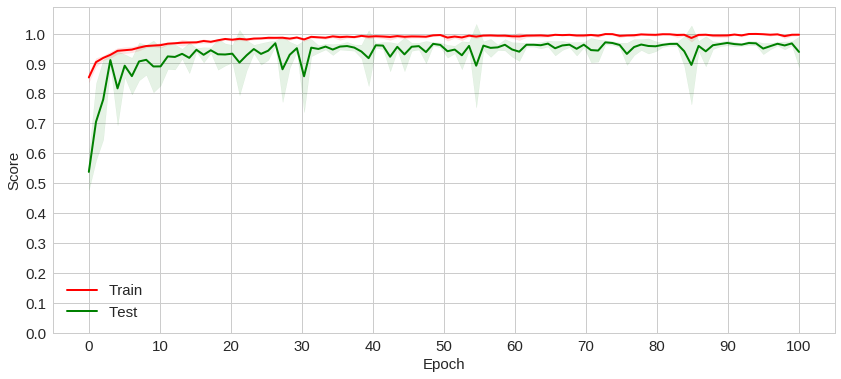

In [24]:
plot_mean_acc(hist)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

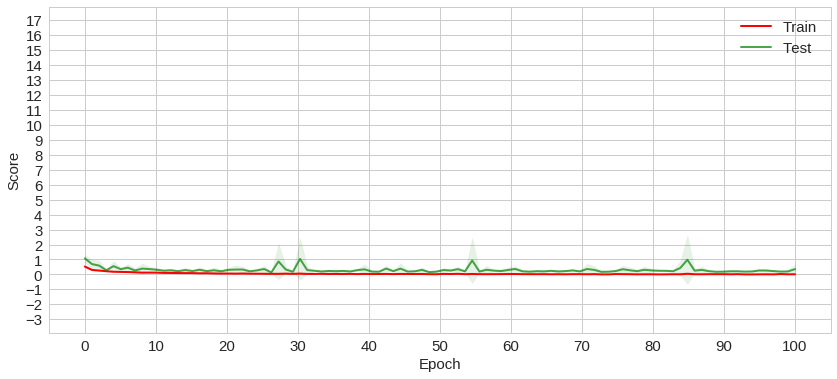

In [26]:
plot_mean_loss(hist)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

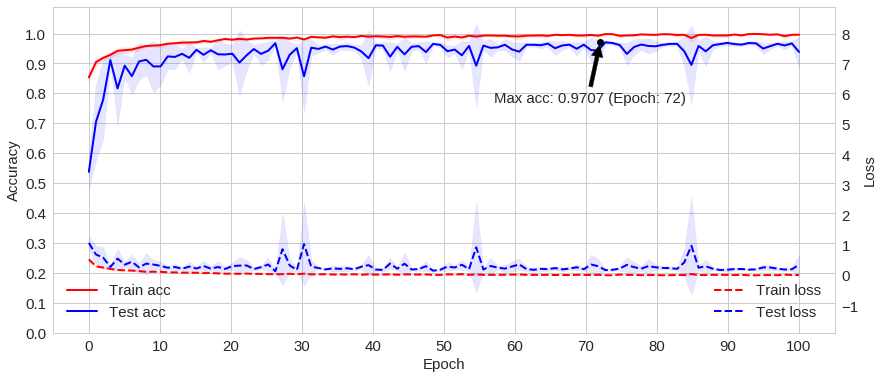

In [28]:
plot_mean(hist)